In [1]:
import os
import netsquid as ns

In [2]:
print("Examples directory: {}".format(os.path.dirname(ns.examples.__file__)))

Examples directory: /Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/examples


## TELEPORTATION.PY 

/Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/util/datacollector.py:239: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/var/folders/l7/fs0hpyl97bq9j90hp_4t90l80000gn/T/ipykernel_18046/2044836856.py:335: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fidelity_data = fidelity_data.append(df)
/Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/util/datacollector.py:239: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/var/folders/l7/fs0hpyl97bq9j90hp_4t90l80000gn/T/ipykernel_18046/2044836856.py:335: FutureWarning: The f

/Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/util/datacollector.py:239: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/var/folders/l7/fs0hpyl97bq9j90hp_4t90l80000gn/T/ipykernel_18046/2044836856.py:335: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  fidelity_data = fidelity_data.append(df)
/Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/util/datacollector.py:239: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
/var/folders/l7/fs0hpyl97bq9j90hp_4t90l80000gn/T/ipykernel_18046/2044836856.py:335: FutureWarning: The f

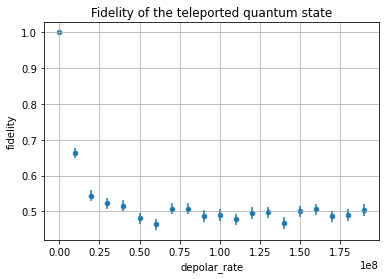

In [3]:
import pandas
from netsquid.components.qprocessor import QuantumProcessor, PhysicalInstruction
from netsquid.nodes import Node, Connection, Network
from netsquid.protocols.protocol import Signals
from netsquid.protocols.nodeprotocols import NodeProtocol
from netsquid.components.qchannel import QuantumChannel
from netsquid.components.cchannel import ClassicalChannel
from netsquid.components.qsource import QSource, SourceStatus
from netsquid.qubits.state_sampler import StateSampler
from netsquid.components.qprogram import QuantumProgram
from netsquid.components.models.qerrormodels import DepolarNoiseModel, DephaseNoiseModel
from netsquid.components.models.delaymodels import FibreDelayModel, FixedDelayModel
from netsquid.util.datacollector import DataCollector
import netsquid as ns
import pydynaa
from netsquid.qubits import ketstates as ks
from netsquid.qubits import qubitapi as qapi
from netsquid.components import instructions as instr

__all__ = [
    "EntanglingConnection",
    "ClassicalConnection",
    "InitStateProgram",
    "BellMeasurementProgram",
    "BellMeasurementProtocol",
    "CorrectionProtocol",
    "create_processor",
    "example_network_setup",
    "example_sim_setup",
    "run_experiment",
    "create_plot",
]


class EntanglingConnection(Connection):
    """A connection that generates entanglement.

    Consists of a midpoint holding a quantum source that connects to
    outgoing quantum channels.

    Parameters
    ----------
    length : float
        End to end length of the connection [km].
    source_frequency : float
        Frequency with which midpoint entanglement source generates entanglement [Hz].
    name : str, optional
        Name of this connection.

    """

    def __init__(self, length, source_frequency, name="EntanglingConnection"):
        super().__init__(name=name)
        qsource = QSource(f"qsource_{name}", StateSampler([ks.b00], [1.0]), num_ports=2,
                          timing_model=FixedDelayModel(delay=1e9 / source_frequency),
                          status=SourceStatus.INTERNAL)
        self.add_subcomponent(qsource, name="qsource")
        qchannel_c2a = QuantumChannel("qchannel_C2A", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        qchannel_c2b = QuantumChannel("qchannel_C2B", length=length / 2,
                                      models={"delay_model": FibreDelayModel()})
        # Add channels and forward quantum channel output to external port output:
        self.add_subcomponent(qchannel_c2a, forward_output=[("A", "recv")])
        self.add_subcomponent(qchannel_c2b, forward_output=[("B", "recv")])
        # Connect qsource output to quantum channel input:
        qsource.ports["qout0"].connect(qchannel_c2a.ports["send"])
        qsource.ports["qout1"].connect(qchannel_c2b.ports["send"])


class ClassicalConnection(Connection):
    """A connection that transmits classical messages in one direction, from A to B.

    Parameters
    ----------
    length : float
        End to end length of the connection [km].
    name : str, optional
       Name of this connection.

    """

    def __init__(self, length, name="ClassicalConnection"):
        super().__init__(name=name)
        self.add_subcomponent(ClassicalChannel("Channel_A2B", length=length,
                                               models={"delay_model": FibreDelayModel()}),
                              forward_input=[("A", "send")],
                              forward_output=[("B", "recv")])


def create_processor(depolar_rate, dephase_rate):
    """Factory to create a quantum processor for each end node.

    Has two memory positions and the physical instructions necessary
    for teleportation.

    Parameters
    ----------
    depolar_rate : float
        Depolarization rate of qubits in memory.
    dephase_rate : float
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`~netsquid.components.qprocessor.QuantumProcessor`
        A quantum processor to specification.

    """
    # We'll give both Alice and Bob the same kind of processor
    measure_noise_model = DephaseNoiseModel(dephase_rate=dephase_rate,
                                            time_independent=True)
    physical_instructions = [
        PhysicalInstruction(instr.INSTR_INIT, duration=3, parallel=True),
        PhysicalInstruction(instr.INSTR_H, duration=1, parallel=True, topology=[0, 1]),
        PhysicalInstruction(instr.INSTR_X, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_Z, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_S, duration=1, parallel=True, topology=[0]),
        PhysicalInstruction(instr.INSTR_CNOT, duration=4, parallel=True, topology=[(0, 1)]),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[0],
                            quantum_noise_model=measure_noise_model, apply_q_noise_after=False),
        PhysicalInstruction(instr.INSTR_MEASURE, duration=7, parallel=False, topology=[1])
    ]
    memory_noise_model = DepolarNoiseModel(depolar_rate=depolar_rate)
    processor = QuantumProcessor("quantum_processor", num_positions=2,
                                 memory_noise_models=[memory_noise_model] * 2,
                                 phys_instructions=physical_instructions)
    return processor


def example_network_setup(node_distance=4e-3, depolar_rate=1e7, dephase_rate=0.2):
    """Setup the physical components of the quantum network.

    Parameters
    ----------
    node_distance : float, optional
        Distance between nodes.
    depolar_rate : float, optional
        Depolarization rate of qubits in memory.
    dephase_rate : float, optional
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`~netsquid.nodes.node.Network`
        A Network with nodes "Alice" and "Bob",
        connected by an entangling connection and a classical connection

    """
    # Setup nodes Alice and Bob with quantum processor:
    alice = Node("Alice", qmemory=create_processor(depolar_rate, dephase_rate))
    bob = Node("Bob", qmemory=create_processor(depolar_rate, dephase_rate))
    # Create a network
    network = Network("Teleportation_network")
    network.add_nodes([alice, bob])
    # Setup classical connection between nodes:
    c_conn = ClassicalConnection(length=node_distance)
    network.add_connection(alice, bob, connection=c_conn, label="classical",
                           port_name_node1="cout_bob", port_name_node2="cin_alice")
    # Setup entangling connection between nodes:
    source_frequency = 4e4 / node_distance
    q_conn = EntanglingConnection(
        length=node_distance, source_frequency=source_frequency)
    port_ac, port_bc = network.add_connection(
        alice, bob, connection=q_conn, label="quantum",
        port_name_node1="qin_charlie", port_name_node2="qin_charlie")
    alice.ports[port_ac].forward_input(alice.qmemory.ports['qin1'])
    bob.ports[port_bc].forward_input(bob.qmemory.ports['qin0'])
    return network


class InitStateProgram(QuantumProgram):
    """Program to create a qubit and transform it to the y0 state.

    """
    default_num_qubits = 1

    def program(self):
        q1, = self.get_qubit_indices(1)
        self.apply(instr.INSTR_INIT, q1)
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_S, q1)
        yield self.run()


class BellMeasurementProgram(QuantumProgram):
    """Program to perform a Bell measurement on two qubits.

    Measurement results are stored in output keys "M1" and "M2"

    """
    default_num_qubits = 2

    def program(self):
        q1, q2 = self.get_qubit_indices(2)
        self.apply(instr.INSTR_CNOT, [q1, q2])
        self.apply(instr.INSTR_H, q1)
        self.apply(instr.INSTR_MEASURE, q1, output_key="M1")
        self.apply(instr.INSTR_MEASURE, q2, output_key="M2")
        yield self.run()


class BellMeasurementProtocol(NodeProtocol):
    """Protocol to perform a Bell measurement when qubits are available.

    """

    def run(self):
        qubit_initialised = False
        entanglement_ready = False
        qubit_init_program = InitStateProgram()
        measure_program = BellMeasurementProgram()
        self.node.qmemory.execute_program(qubit_init_program)
        while True:
            expr = yield (self.await_program(self.node.qmemory) |
                          self.await_port_input(self.node.ports["qin_charlie"]))
            if expr.first_term.value:
                qubit_initialised = True
            else:
                entanglement_ready = True
            if qubit_initialised and entanglement_ready:
                # Once both qubits arrived, do BSM program and send to Bob
                yield self.node.qmemory.execute_program(measure_program)
                m1, = measure_program.output["M1"]
                m2, = measure_program.output["M2"]
                self.node.ports["cout_bob"].tx_output((m1, m2))
                self.send_signal(Signals.SUCCESS)
                qubit_initialised = False
                entanglement_ready = False
                self.node.qmemory.execute_program(qubit_init_program)


class CorrectionProtocol(NodeProtocol):
    """Protocol to perform corrections on Bobs qubit when available and measurements received

    """

    def run(self):
        port_alice = self.node.ports["cin_alice"]
        port_charlie = self.node.ports["qin_charlie"]
        entanglement_ready = False
        meas_results = None
        while True:
            # Wait for measurement results of Alice or qubit from Charlie to arrive
            expr = yield (self.await_port_input(port_alice) |
                          self.await_port_input(port_charlie))
            if expr.first_term.value:  # If measurements from Alice arrived
                meas_results, = port_alice.rx_input().items
            else:
                entanglement_ready = True
            if meas_results is not None and entanglement_ready:
                # Do corrections (blocking)
                if meas_results[0] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_Z)
                    yield self.await_program(self.node.qmemory)
                if meas_results[1] == 1:
                    self.node.qmemory.execute_instruction(instr.INSTR_X)
                    yield self.await_program(self.node.qmemory)
                self.send_signal(Signals.SUCCESS, 0)
                entanglement_ready = False
                meas_results = None


def example_sim_setup(node_A, node_B):
    """Example simulation setup with data collector for teleportation protocol.

    Parameters
    ----------
    node_A : :class:`~netsquid.nodes.node.Node`
        Node corresponding to Alice.
    node_B : :class:`~netsquid.nodes.node.Node`
        Node corresponding to Bob.

    Returns
    -------
    :class:`~netsquid.protocols.protocol.Protocol`
        Alice's protocol.
    :class:`~netsquid.protocols.protocol.Protocol`
        Bob's protocol.
    :class:`~netsquid.util.datacollector.DataCollector`
        Data collector to record fidelity.

    """

    def collect_fidelity_data(evexpr):
        protocol = evexpr.triggered_events[-1].source
        mem_pos = protocol.get_signal_result(Signals.SUCCESS)
        qubit, = protocol.node.qmemory.pop(mem_pos)
        fidelity = qapi.fidelity(qubit, ns.y0, squared=True)
        qapi.discard(qubit)
        return {"fidelity": fidelity}

    protocol_alice = BellMeasurementProtocol(node_A)
    protocol_bob = CorrectionProtocol(node_B)
    dc = DataCollector(collect_fidelity_data)
    dc.collect_on(pydynaa.EventExpression(source=protocol_bob,
                                          event_type=Signals.SUCCESS.value))
    return protocol_alice, protocol_bob, dc


def run_experiment(num_runs, depolar_rates, distance=4e-3, dephase_rate=0.0):
    """Setup and run the simulation experiment.

    Parameters
    ----------
    num_runs : int
        Number of cycles to run teleportation for.
    depolar_rates : list of float
        List of depolarization rates to repeat experiment for.
    distance : float, optional
        Distance between nodes [km].
    dephase_rate : float, optional
        Dephasing rate of physical measurement instruction.

    Returns
    -------
    :class:`pandas.DataFrame`
        Dataframe with recorded fidelity data.

    """
    fidelity_data = pandas.DataFrame()
    for i, depolar_rate in enumerate(depolar_rates):
        ns.sim_reset()
        network = example_network_setup(distance, depolar_rate, dephase_rate)
        node_a = network.get_node("Alice")
        node_b = network.get_node("Bob")
        protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
        protocol_alice.start()
        protocol_bob.start()
        q_conn = network.get_connection(node_a, node_b, label="quantum")
        cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                         .models["timing_model"].delay)
        ns.sim_run(cycle_runtime * num_runs + 1)
        df = dc.dataframe
        df['depolar_rate'] = depolar_rate
        fidelity_data = fidelity_data.append(df)
    return fidelity_data


def create_plot():
    """Show a plot of fidelity verus depolarization rate.

    """
    from matplotlib import pyplot as plt
    depolar_rates = [1e6 * i for i in range(0, 200, 10)]
    fidelities = run_experiment(num_runs=1000, distance=4e-3,
                                depolar_rates=depolar_rates, dephase_rate=0.0)
    plot_style = {'kind': 'scatter', 'grid': True,
                  'title': "Fidelity of the teleported quantum state"}
    data = fidelities.groupby("depolar_rate")['fidelity'].agg(
        fidelity='mean', sem='sem').reset_index()
    data.plot(x='depolar_rate', y='fidelity', yerr='sem', **plot_style)
    plt.show()


if __name__ == '__main__':
    create_plot()


In [9]:
ns.sim_reset()

In [10]:
from netsquid.examples.teleportation import (
    example_network_setup, example_sim_setup)
network = example_network_setup(node_distance=4e-3, depolar_rate=0, dephase_rate=0)
node_a = network.get_node("Alice")
node_b = network.get_node("Bob")
protocol_alice, protocol_bob, dc = example_sim_setup(node_a, node_b)
protocol_alice.start()
protocol_bob.start()
q_conn = network.get_connection(node_a, node_b, label="quantum")
cycle_runtime = (q_conn.subcomponents["qsource"].subcomponents["internal_clock"]
                 .models["timing_model"].delay)
ns.sim_run(cycle_runtime * 100)
print(f"Mean fidelity of teleported state: {dc.dataframe['fidelity'].mean():.3f}")

Mean fidelity of teleported state: 1.000


/Users/ashrit/opt/anaconda3/lib/python3.8/site-packages/netsquid/util/datacollector.py:239: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self._dataframe = self._dataframe.append(self._data_buffer, ignore_index=True, sort=False)
